In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.stats import ttest_ind
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy import barplot, dotplot
from gseapy.plot import gseaplot
from sanbomics.plots import volcano
from sanbomics.tools import id_map
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from skopt import BayesSearchCV
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Evaluation function

In [2]:
def allscore(model, onet, twot):
    # Make predictions
    y_pred = model.predict(onet)

    # Calculate evaluation metrics
    accuracy = accuracy_score(twot, y_pred)
    precision = precision_score(twot, y_pred)
    recall = recall_score(twot, y_pred)
    f1 = f1_score(twot, y_pred)
    cm = confusion_matrix(twot, y_pred)

    # Print evaluation results
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n",cm)

    # Print classification report
    report = classification_report(twot, y_pred)
    print("\nClassification Report:\n", report)

We define this function to make it easier to evaluate each of the ML algorithms

# BayesSearchCV hyperparameter space

In [3]:
lr = BayesSearchCV(
   LogisticRegression(),
    {'C':[0.01, 0.1, 1.0, 10.0,100] , 
     'class_weight':['balanced'] ,
     'solver':[ 'liblinear', 'newton-cholesky'],
    'max_iter': [100,10000]}, n_iter=50, cv=5,
random_state=69 )

In [4]:
svm = BayesSearchCV(
   SVC(),
    {'C':[0.01, 0.1, 1.0, 10.0,100] , 
     'gamma':['scale', 'auto'] ,
     'kernel':[ 'linear', 'poly', 'rbf'] }, n_iter=50, cv=5,
random_state=69 )

In [5]:
rfc = BayesSearchCV(
   RandomForestClassifier(),
    {
                                'ccp_alpha':[0.01,0.1,0.0,1.0,10], 
                                'class_weight': ['balanced'],
                                'max_depth':[5,15],
                                'max_features':['log2'],
                               'max_leaf_nodes':[18],
                               'max_samples':[None],
                               'min_impurity_decrease': [0.01,0.1],
                               'min_samples_split':[2,6],
                                'min_samples_leaf':[1,2,3,4],
                               'min_weight_fraction_leaf':[0.07],
                               'n_estimators':[300,500],
                               'criterion' : ['entropy'],
                               'bootstrap': [False]    
    }, n_iter=50, cv=5,
random_state=69 )

In [6]:
xgbc = BayesSearchCV(
   xgb.XGBClassifier(),
    {
                                'base_score':[0.01,0.5], 
                                'booster': ['dart'],
                                'max_depth':[5,15],
                                'max_bin':[30,45],
                                'max_delta_step':[10,15],
                                'learning_rate':[0.01,0.1],
                                'min_child_weight':[0.1,0.5],
                                'num_parallel_tree':[3,10],
                                'grow_policy':['lossguide'],
                                'gamma':[0.01,0.5],
                               'max_leaves':[15,25],
                               'reg_lambda':[None,],
                               'importance_type': ['cover'],
                               'colsample_bylevel':[0.01,0.4],
                                'colsample_bynode':[0.01,0.4],
                               'colsample_bytree':[0.01,0.4],
                               'n_estimators':[300,500],
                               'objective' : ['binary:logistic'],
                               'subsample': [0.6,0.99]    
    }, n_iter=50, cv=5,
random_state=69 )

In [7]:
xgbc1= xgbc
xgbc2= xgbc
xgbc3= xgbc
xgbc4= xgbc

We define the search ranges for the ML algorithms (This was refined following many iterations)

# Raw counts datasets preprocessing

In [8]:
traindf = pd.read_csv(r"\traintest.txt", sep='\t')
valdf = pd.read_csv(r"\valset.txt", sep='\t')

## ML datasets no log transformation no scaling

In [9]:
X = traindf.drop(columns='condition')
y= traindf['condition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=69)

In [10]:
a = valdf.drop(columns='condition')
b = valdf['condition']

## ML datasets log transformed

In [11]:
transformedx = np.log1p(X)
logX_train, logX_test, logy_train, logy_test = train_test_split(transformedx, y, test_size=0.30, random_state=69)

In [12]:
logvala = np.log1p(a)

## ML datasets scaled

In [13]:
# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
asca = scaler.fit_transform(a)
Xcorr= pd.DataFrame(X_scaled, columns= X.columns)
# Split the data into training and testing sets
X_trains, X_tests, y_trains, y_tests = train_test_split(Xcorr, y, test_size=0.3, random_state=69)

## ML datasets log transformed then scaled

In [14]:
transformedx = np.log1p(X)
logvala = np.log1p(a)
X_scaled = scaler.fit_transform(transformedx)
a_scaled = scaler.fit_transform(logvala)
Xlogsca= pd.DataFrame(X_scaled, columns=X.columns)
acorr= pd.DataFrame(a_scaled, columns=a.columns)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xlogsca, y, test_size=0.3, random_state=69)

# TPM datasets preprocessing

In [15]:
tpmdf= pd.read_csv(r"\tpm4mltt.txt", sep='\t')

In [16]:
tpmvaldf= pd.read_csv(r"\tpmval4ml.txt", sep='\t')

## Datasets no log transformation no scaling

In [17]:
tX= tpmdf.drop(columns='condition')
ty= tpmdf['condition']
tX_train, tX_test, ty_train, ty_test = train_test_split(tX, ty, test_size=0.30, random_state=69)

In [18]:
ta= tpmvaldf.drop(columns='condition')
tb= tpmvaldf['condition']

## Datasets log transformed

In [19]:
transformedx = np.log1p(tX)
tlogX_train, tlogX_test, tlogy_train, tlogy_test = train_test_split(transformedx, ty, test_size=0.30, random_state=69)

In [20]:
tlogvala= np.log1p(ta)

## Datasets scaled

In [21]:
# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(tX)
tX_scaled = pd.DataFrame(X_scaled, columns=tX.columns)
tX_trains, tX_tests, ty_trains, ty_tests = train_test_split(tX_scaled, ty, test_size=0.3, random_state=69)

In [22]:
ta_scaled = scaler.fit_transform(ta)
tasca = pd.DataFrame(ta_scaled,columns=ta.columns)

## Datasets log transformed and scaled

In [23]:
rtransformedx = np.log1p(tX)
trX_scaled = scaler.fit_transform(rtransformedx)
trXcorr= pd.DataFrame(trX_scaled, columns=tX.columns)
trXtrain, trXtest,trytrain, trytest = train_test_split(trXcorr, ty, test_size=0.3, random_state=69)

In [24]:
tra_scaled= scaler.fit_transform(tlogvala)
tracorr= pd.DataFrame(tra_scaled,columns=ta.columns)

# RAW COUNTS

# ML models training no log transformation

## LR

In [50]:
lr.fit(X_train, y_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

### Retraining

In [51]:
lrmodel = LogisticRegression(**lr.best_params_)

In [52]:
lrmodel.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=9649,
                   solver='liblinear')

## SVM

In [53]:
svm.fit(X_train, y_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

### SVM retraining

In [54]:
svmodel = SVC(**svm.best_params_)

In [55]:
svmodel.fit(X_train,y_train)

SVC(kernel='poly')

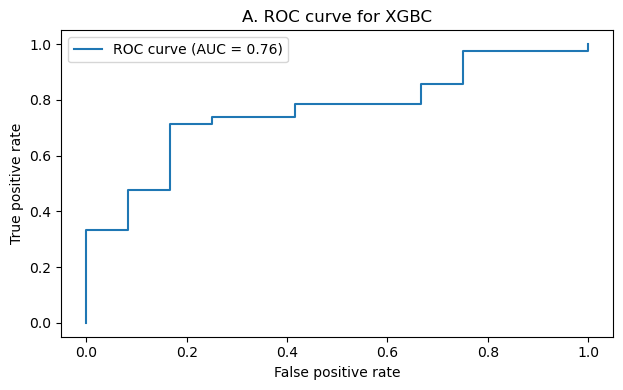

In [47]:
y_pred= svmodel.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
auc = metrics.auc(fpr,tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(12, 4))
# previously defined AUC and fpr/tpr for single figures
# First subplot for ROC curve
plt.subplot(121)  # 1 row, 2 columns, first subplot
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('A. ROC curve for XGBC')
plt.legend()
plt.tight_layout()  # So that the subplots don't overlap

plt.show()

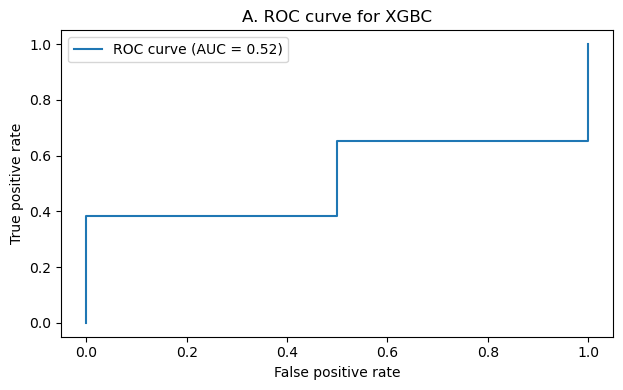

In [48]:
y_pred= svmodel.decision_function(a)
fpr, tpr, thresholds = roc_curve(b, y_pred) 
auc = metrics.auc(fpr,tpr)
precision, recall, thresholds = precision_recall_curve(b, y_pred)

plt.figure(figsize=(12, 4))
# previously defined AUC and fpr/tpr for single figures
# First subplot for ROC curve
plt.subplot(121)  # 1 row, 2 columns, first subplot
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('A. ROC curve for XGBC')
plt.legend()

plt.tight_layout()  # So that the subplots don't overlap

plt.show()

## RFC

In [56]:
rfc.fit(X_train,y_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

### RFC retraining

In [57]:
rfcmodel = RandomForestClassifier(**rfc.best_params_)

In [58]:
rfcmodel.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18,
                       min_impurity_decrease=0.016686940251626328,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.07, n_estimators=300)

## XGBoostC

In [34]:
xgbc1.fit(X_train,y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [35]:
xgbcmodel= xgb.XGBClassifier(**xgbc1.best_params_)

In [36]:
xgbcmodel.fit(X_train,y_train)

XGBClassifier(base_score=0.1473005068920344, booster='dart', callbacks=None,
              colsample_bylevel=0.32701875208354564,
              colsample_bynode=0.09345193616997369,
              colsample_bytree=0.056176998293711866, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.05667386300633147,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.09301432682257324,
              max_bin=39, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=8, max_leaves=25,
              min_child_weight=0.49999999980161747, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=319,
              n_jobs=None, num_parallel_tree=9, random_state=None, ...)

# model evaluation

### LR testing and validation

In [86]:
allscore(lrmodel,X_test, y_test)

Accuracy: 0.7407407407407407
Precision: 0.868421052631579
Recall: 0.7857142857142857
F1 Score: 0.825
Confusion Matrix:
 [[ 7  5]
 [ 9 33]]

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.58      0.50        12
           1       0.87      0.79      0.82        42

    accuracy                           0.74        54
   macro avg       0.65      0.68      0.66        54
weighted avg       0.77      0.74      0.75        54



In [87]:
allscore(lrmodel, a,b)

Accuracy: 0.7142857142857143
Precision: 0.9090909090909091
Recall: 0.7692307692307693
F1 Score: 0.8333333333333333
Confusion Matrix:
 [[ 0  2]
 [ 6 20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      0.77      0.83        26

    accuracy                           0.71        28
   macro avg       0.45      0.38      0.42        28
weighted avg       0.84      0.71      0.77        28



### SVM testing and validation

In [88]:
allscore(svmodel, X_test, y_test)

Accuracy: 0.7592592592592593
Precision: 0.7735849056603774
Recall: 0.9761904761904762
F1 Score: 0.863157894736842
Confusion Matrix:
 [[ 0 12]
 [ 1 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.98      0.86        42

    accuracy                           0.76        54
   macro avg       0.39      0.49      0.43        54
weighted avg       0.60      0.76      0.67        54



In [89]:
allscore(svmodel, a, b)

Accuracy: 0.9285714285714286
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963
Confusion Matrix:
 [[ 0  2]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        26

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RFC testing and validation

In [90]:
allscore(rfcmodel,X_test,y_test)

Accuracy: 0.7407407407407407
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334
Confusion Matrix:
 [[ 5  7]
 [ 7 35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.42      0.42        12
           1       0.83      0.83      0.83        42

    accuracy                           0.74        54
   macro avg       0.62      0.62      0.62        54
weighted avg       0.74      0.74      0.74        54



In [91]:
allscore(rfcmodel, a,b)

Accuracy: 0.8928571428571429
Precision: 0.96
Recall: 0.9230769230769231
F1 Score: 0.9411764705882353
Confusion Matrix:
 [[ 1  1]
 [ 2 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.96      0.92      0.94        26

    accuracy                           0.89        28
   macro avg       0.65      0.71      0.67        28
weighted avg       0.92      0.89      0.90        28



### XGBC

In [92]:
allscore(xgbcmodel, X_test,y_test)

Accuracy: 0.8333333333333334
Precision: 0.8235294117647058
Recall: 1.0
F1 Score: 0.9032258064516129
Confusion Matrix:
 [[ 3  9]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.82      1.00      0.90        42

    accuracy                           0.83        54
   macro avg       0.91      0.62      0.65        54
weighted avg       0.86      0.83      0.79        54



In [93]:
allscore(xgbcmodel,a,b)

Accuracy: 0.9285714285714286
Precision: 0.9615384615384616
Recall: 0.9615384615384616
F1 Score: 0.9615384615384616
Confusion Matrix:
 [[ 1  1]
 [ 1 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.96      0.96      0.96        26

    accuracy                           0.93        28
   macro avg       0.73      0.73      0.73        28
weighted avg       0.93      0.93      0.93        28



# ML models training log transformed no scaling

## LR

In [59]:
lr.fit(logX_train, logy_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

### Retraining

In [60]:
lolrmodel = LogisticRegression(**lr.best_params_)

In [61]:
lolrmodel.fit(logX_train,logy_train)

LogisticRegression(class_weight='balanced', max_iter=1898, solver='liblinear')

In [311]:
lrcoefs = lolrmodel.coef_ # take coefficients list
sortedlrcoefsarr = sorted(lrcoefs, key= abs) # sort the coefficients
sortedlrcoefs = [x for y in sortedlrcoefsarr for x in y] # make a list of the list in the array

In [312]:
features = list(X.columns)

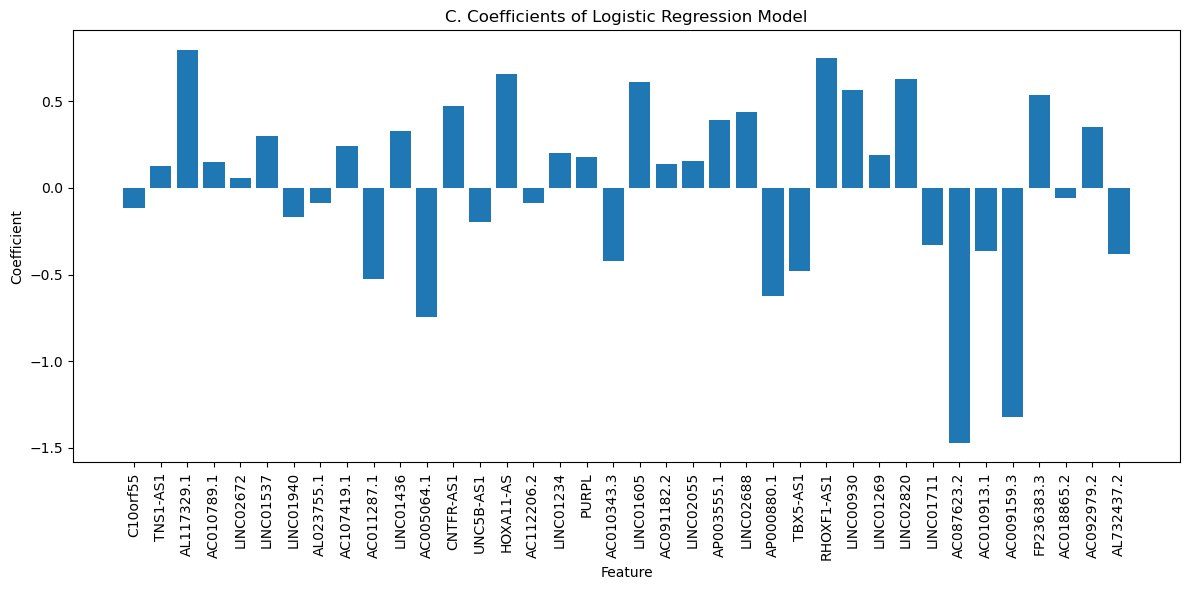

In [313]:
plt.figure(figsize = (12,6))
plt.bar(features,sortedlrcoefs)
plt.xticks(rotation = 90)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("C. Coefficients of Logistic Regression Model")
plt.tight_layout()
plt.show()

## SVM

In [62]:
svm.fit(logX_train, logy_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

### SVM retraining

In [63]:
losvmodel = SVC(**svm.best_params_)

In [64]:
losvmodel.fit(logX_train,logy_train)

SVC()

## RFC

In [65]:
rfc.fit(logX_train,logy_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

### RFC retraining

In [66]:
lorfcmodel = RandomForestClassifier(**rfc.best_params_)

In [67]:
lorfcmodel.fit(logX_train,logy_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18, min_impurity_decrease=0.01,
                       min_samples_leaf=3, min_samples_split=6,
                       min_weight_fraction_leaf=0.07, n_estimators=468)

## XGBC

In [38]:
xgbc2.fit(logX_train, logy_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [39]:
loxgbc= xgb.XGBClassifier(**xgbc2.best_params_)

In [40]:
loxgbc.fit(logX_train,logy_train)

XGBClassifier(base_score=0.1473005068920344, booster='dart', callbacks=None,
              colsample_bylevel=0.32701875208354564,
              colsample_bynode=0.09345193616997369,
              colsample_bytree=0.056176998293711866, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.05667386300633147,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.09301432682257324,
              max_bin=39, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=8, max_leaves=25,
              min_child_weight=0.49999999980161747, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=319,
              n_jobs=None, num_parallel_tree=9, random_state=None, ...)

# model evaluation

### LR testing and validation

In [94]:
allscore(lolrmodel, logX_test, logy_test)

Accuracy: 0.8148148148148148
Precision: 0.8636363636363636
Recall: 0.9047619047619048
F1 Score: 0.8837209302325582
Confusion Matrix:
 [[ 6  6]
 [ 4 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.86      0.90      0.88        42

    accuracy                           0.81        54
   macro avg       0.73      0.70      0.71        54
weighted avg       0.81      0.81      0.81        54



In [95]:
allscore(lolrmodel, logvala,b)

Accuracy: 0.7857142857142857
Precision: 0.9545454545454546
Recall: 0.8076923076923077
F1 Score: 0.875
Confusion Matrix:
 [[ 1  1]
 [ 5 21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.50      0.25         2
           1       0.95      0.81      0.88        26

    accuracy                           0.79        28
   macro avg       0.56      0.65      0.56        28
weighted avg       0.90      0.79      0.83        28



### SVM testing and validation

In [96]:
allscore(losvmodel,logX_test,logy_test)

Accuracy: 0.7777777777777778
Precision: 0.7777777777777778
Recall: 1.0
F1 Score: 0.8750000000000001
Confusion Matrix:
 [[ 0 12]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.78      1.00      0.88        42

    accuracy                           0.78        54
   macro avg       0.39      0.50      0.44        54
weighted avg       0.60      0.78      0.68        54



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
allscore(losvmodel, logvala,b)

Accuracy: 0.9285714285714286
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963
Confusion Matrix:
 [[ 0  2]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        26

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RFC testing and validation

In [98]:
allscore(lorfcmodel, logX_test, logy_test)

Accuracy: 0.7222222222222222
Precision: 0.8292682926829268
Recall: 0.8095238095238095
F1 Score: 0.8192771084337348
Confusion Matrix:
 [[ 5  7]
 [ 8 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.83      0.81      0.82        42

    accuracy                           0.72        54
   macro avg       0.61      0.61      0.61        54
weighted avg       0.73      0.72      0.73        54



In [99]:
allscore(lorfcmodel, logvala, b)

Accuracy: 0.8928571428571429
Precision: 0.96
Recall: 0.9230769230769231
F1 Score: 0.9411764705882353
Confusion Matrix:
 [[ 1  1]
 [ 2 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.96      0.92      0.94        26

    accuracy                           0.89        28
   macro avg       0.65      0.71      0.67        28
weighted avg       0.92      0.89      0.90        28



### XGBC

In [100]:
allscore(loxgbc,logX_test,logy_test)

Accuracy: 0.8333333333333334
Precision: 0.8235294117647058
Recall: 1.0
F1 Score: 0.9032258064516129
Confusion Matrix:
 [[ 3  9]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.82      1.00      0.90        42

    accuracy                           0.83        54
   macro avg       0.91      0.62      0.65        54
weighted avg       0.86      0.83      0.79        54



In [101]:
allscore(loxgbc,logvala,b)

Accuracy: 0.9285714285714286
Precision: 0.9615384615384616
Recall: 0.9615384615384616
F1 Score: 0.9615384615384616
Confusion Matrix:
 [[ 1  1]
 [ 1 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.96      0.96      0.96        26

    accuracy                           0.93        28
   macro avg       0.73      0.73      0.73        28
weighted avg       0.93      0.93      0.93        28



# Scaled but not log transformed

## LR

In [68]:
lr.fit(X_trains, y_trains)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

### Retraining

In [69]:
lrmodels = LogisticRegression(**lr.best_params_)

In [70]:
lrmodels.fit(X_trains,y_trains)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=2136,
                   solver='newton-cholesky')

## SVM

In [71]:
svm.fit(X_trains, y_trains)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

### SVM retraining

In [72]:
svmodels = SVC(**svm.best_params_)

In [73]:
svmodels.fit(X_trains,y_trains)

SVC(gamma='auto', kernel='linear')

## RFC

In [74]:
rfc.fit(X_trains,y_trains)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

### RFC retraining

In [75]:
rfcmodels = RandomForestClassifier(**rfc.best_params_)

In [76]:
rfcmodels.fit(X_trains,y_trains)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18, min_impurity_decrease=0.01,
                       min_weight_fraction_leaf=0.07, n_estimators=300)

## XGBC

In [41]:
xgbc3.fit(X_trains,y_trains)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [42]:
xgbcmodels= xgb.XGBClassifier(**xgbc3.best_params_)

In [43]:
xgbcmodels.fit(X_trains,y_trains)

XGBClassifier(base_score=0.1473005068920344, booster='dart', callbacks=None,
              colsample_bylevel=0.32701875208354564,
              colsample_bynode=0.09345193616997369,
              colsample_bytree=0.056176998293711866, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.05667386300633147,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.09301432682257324,
              max_bin=39, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=8, max_leaves=25,
              min_child_weight=0.49999999980161747, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=319,
              n_jobs=None, num_parallel_tree=9, random_state=None, ...)

# model evaluation

### LR testing and validation

In [102]:
allscore(lrmodels, X_tests, y_tests)

Accuracy: 0.7592592592592593
Precision: 0.8372093023255814
Recall: 0.8571428571428571
F1 Score: 0.8470588235294119
Confusion Matrix:
 [[ 5  7]
 [ 6 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.84      0.86      0.85        42

    accuracy                           0.76        54
   macro avg       0.65      0.64      0.64        54
weighted avg       0.75      0.76      0.76        54



In [103]:
allscore(lrmodels, asca,b)

Accuracy: 0.35714285714285715
Precision: 0.9
Recall: 0.34615384615384615
F1 Score: 0.5
Confusion Matrix:
 [[ 1  1]
 [17  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.50      0.10         2
           1       0.90      0.35      0.50        26

    accuracy                           0.36        28
   macro avg       0.48      0.42      0.30        28
weighted avg       0.84      0.36      0.47        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### SVM testing and validation

In [104]:
allscore(svmodels,X_tests,y_tests)

Accuracy: 0.8148148148148148
Precision: 0.8076923076923077
Recall: 1.0
F1 Score: 0.8936170212765957
Confusion Matrix:
 [[ 2 10]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.81      1.00      0.89        42

    accuracy                           0.81        54
   macro avg       0.90      0.58      0.59        54
weighted avg       0.85      0.81      0.76        54



In [105]:
allscore(svmodels, asca,b)

Accuracy: 0.6428571428571429
Precision: 0.9444444444444444
Recall: 0.6538461538461539
F1 Score: 0.7727272727272727
Confusion Matrix:
 [[ 1  1]
 [ 9 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.50      0.17         2
           1       0.94      0.65      0.77        26

    accuracy                           0.64        28
   macro avg       0.52      0.58      0.47        28
weighted avg       0.88      0.64      0.73        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


### RFC testing and validation

In [106]:
allscore(rfcmodels,X_tests, y_tests)

Accuracy: 0.7222222222222222
Precision: 0.8292682926829268
Recall: 0.8095238095238095
F1 Score: 0.8192771084337348
Confusion Matrix:
 [[ 5  7]
 [ 8 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.83      0.81      0.82        42

    accuracy                           0.72        54
   macro avg       0.61      0.61      0.61        54
weighted avg       0.73      0.72      0.73        54



In [107]:
allscore(rfcmodels, asca,b)

Accuracy: 0.7142857142857143
Precision: 0.95
Recall: 0.7307692307692307
F1 Score: 0.8260869565217392
Confusion Matrix:
 [[ 1  1]
 [ 7 19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.50      0.20         2
           1       0.95      0.73      0.83        26

    accuracy                           0.71        28
   macro avg       0.54      0.62      0.51        28
weighted avg       0.89      0.71      0.78        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### XGBC

In [108]:
allscore(xgbcmodels,X_tests,y_tests)

Accuracy: 0.8333333333333334
Precision: 0.8235294117647058
Recall: 1.0
F1 Score: 0.9032258064516129
Confusion Matrix:
 [[ 3  9]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.82      1.00      0.90        42

    accuracy                           0.83        54
   macro avg       0.91      0.62      0.65        54
weighted avg       0.86      0.83      0.79        54



In [109]:
allscore(xgbcmodels, asca,b)

Accuracy: 0.8928571428571429
Precision: 0.96
Recall: 0.9230769230769231
F1 Score: 0.9411764705882353
Confusion Matrix:
 [[ 1  1]
 [ 2 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.96      0.92      0.94        26

    accuracy                           0.89        28
   macro avg       0.65      0.71      0.67        28
weighted avg       0.92      0.89      0.90        28



# ML log transformed and scaled

## LR

In [77]:
lr.fit(Xtrain, ytrain)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

### Retraining

In [78]:
lrmo = LogisticRegression(**lr.best_params_)

In [79]:
lrmo.fit(Xtrain, ytrain)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=135,
                   solver='liblinear')

## SVM

In [80]:
svm.fit(Xtrain, ytrain)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

### SVM retraining

In [81]:
svmo = SVC(**svm.best_params_)

In [82]:
svmo.fit(Xtrain, ytrain)

SVC(C=0.1, kernel='poly')

## RFC

In [83]:
rfc.fit(Xtrain, ytrain)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

### RFC retraining

In [84]:
rfcmo = RandomForestClassifier(**rfc.best_params_)

In [85]:
rfcmo.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features='log2',
                       max_leaf_nodes=18,
                       min_impurity_decrease=0.016836234377102022,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.07, n_estimators=300)

## XGBC

In [44]:
xgbc4.fit(Xtrain, ytrain)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

### retraining

In [45]:
xgbcmo= xgb.XGBClassifier(**xgbc4.best_params_)

In [46]:
xgbcmo.fit(Xtrain,ytrain)

XGBClassifier(base_score=0.1473005068920344, booster='dart', callbacks=None,
              colsample_bylevel=0.32701875208354564,
              colsample_bynode=0.09345193616997369,
              colsample_bytree=0.056176998293711866, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.05667386300633147,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.09301432682257324,
              max_bin=39, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=8, max_leaves=25,
              min_child_weight=0.49999999980161747, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=319,
              n_jobs=None, num_parallel_tree=9, random_state=None, ...)

# model evaluation

### LR testing and validation

In [110]:
allscore(lrmo,Xtest,ytest)

Accuracy: 0.7037037037037037
Precision: 0.825
Recall: 0.7857142857142857
F1 Score: 0.8048780487804876
Confusion Matrix:
 [[ 5  7]
 [ 9 33]]

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.42      0.38        12
           1       0.82      0.79      0.80        42

    accuracy                           0.70        54
   macro avg       0.59      0.60      0.59        54
weighted avg       0.72      0.70      0.71        54



In [111]:
allscore(lrmo,acorr,b)

Accuracy: 0.7857142857142857
Precision: 0.9545454545454546
Recall: 0.8076923076923077
F1 Score: 0.875
Confusion Matrix:
 [[ 1  1]
 [ 5 21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.50      0.25         2
           1       0.95      0.81      0.88        26

    accuracy                           0.79        28
   macro avg       0.56      0.65      0.56        28
weighted avg       0.90      0.79      0.83        28



### SVM testing and validation

In [112]:
allscore(svmo,Xtest,ytest)

Accuracy: 0.7962962962962963
Precision: 0.8163265306122449
Recall: 0.9523809523809523
F1 Score: 0.8791208791208791
Confusion Matrix:
 [[ 3  9]
 [ 2 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.25      0.35        12
           1       0.82      0.95      0.88        42

    accuracy                           0.80        54
   macro avg       0.71      0.60      0.62        54
weighted avg       0.77      0.80      0.76        54



In [113]:
allscore(svmo,acorr,b)

Accuracy: 0.8571428571428571
Precision: 0.9583333333333334
Recall: 0.8846153846153846
F1 Score: 0.9199999999999999
Confusion Matrix:
 [[ 1  1]
 [ 3 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.96      0.88      0.92        26

    accuracy                           0.86        28
   macro avg       0.60      0.69      0.63        28
weighted avg       0.91      0.86      0.88        28



### RFC testing and validation

In [114]:
allscore(rfcmo,Xtest,ytest)

Accuracy: 0.7222222222222222
Precision: 0.8292682926829268
Recall: 0.8095238095238095
F1 Score: 0.8192771084337348
Confusion Matrix:
 [[ 5  7]
 [ 8 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.83      0.81      0.82        42

    accuracy                           0.72        54
   macro avg       0.61      0.61      0.61        54
weighted avg       0.73      0.72      0.73        54



In [115]:
allscore(rfcmo,acorr,b)

Accuracy: 0.7142857142857143
Precision: 1.0
Recall: 0.6923076923076923
F1 Score: 0.8181818181818181
Confusion Matrix:
 [[ 2  0]
 [ 8 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.20      1.00      0.33         2
           1       1.00      0.69      0.82        26

    accuracy                           0.71        28
   macro avg       0.60      0.85      0.58        28
weighted avg       0.94      0.71      0.78        28



### XGBC

In [116]:
allscore(xgbcmo, Xtest,ytest)

Accuracy: 0.8333333333333334
Precision: 0.8235294117647058
Recall: 1.0
F1 Score: 0.9032258064516129
Confusion Matrix:
 [[ 3  9]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.82      1.00      0.90        42

    accuracy                           0.83        54
   macro avg       0.91      0.62      0.65        54
weighted avg       0.86      0.83      0.79        54



In [117]:
allscore(xgbcmo, acorr, b)

Accuracy: 0.8571428571428571
Precision: 0.9583333333333334
Recall: 0.8846153846153846
F1 Score: 0.9199999999999999
Confusion Matrix:
 [[ 1  1]
 [ 3 23]]

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.96      0.88      0.92        26

    accuracy                           0.86        28
   macro avg       0.60      0.69      0.63        28
weighted avg       0.91      0.86      0.88        28



# Raw counts models visualization

## Nonscaled nonlogged

In [118]:
# Get predicted probabilities or decision values for each model
lr_probs = lrmodel.predict_proba(X_test)[:, 1]  # Logistic Regression
svm_probs = svmodel.decision_function(X_test)   # SVM
rfc_probs = rfcmodel.predict_proba(X_test)[:, 1]  # Random Forest
xgb_probs = xgbcmodel.predict_proba(X_test)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [119]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = lrmodel.predict_proba(a)[:, 1]  # Logistic Regression
svm_probs_val = svmodel.decision_function(a)    # SVM
rfc_probs_val = rfcmodel.predict_proba(a)[:, 1]  # Random Forest
xgb_probs_val = xgbcmodel.predict_proba(a)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(b, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(b, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(b, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(b, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

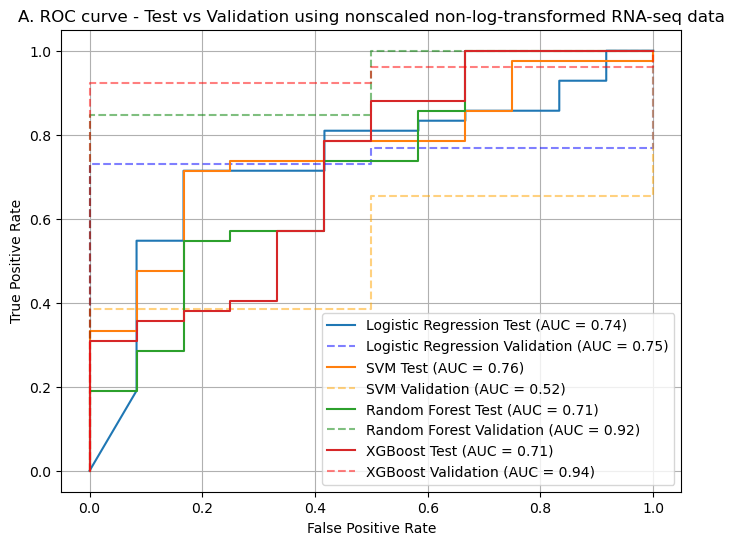

In [120]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('A. ROC curve - Test vs Validation using nonscaled non-log-transformed RNA-seq data')
plt.legend()
plt.grid(True)
plt.show()


## logged

In [121]:
# Get predicted probabilities or decision values for each model
lr_probs = lolrmodel.predict_proba(logX_test)[:, 1]  # Logistic Regression
svm_probs = losvmodel.decision_function(logX_test)   # SVM
rfc_probs = lorfcmodel.predict_proba(logX_test)[:, 1]  # Random Forest
xgb_probs = loxgbc.predict_proba(logX_test)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(logy_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(logy_test, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(logy_test, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(logy_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [122]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = lolrmodel.predict_proba(logvala)[:, 1]  # Logistic Regression
svm_probs_val = losvmodel.decision_function(logvala)    # SVM
rfc_probs_val = lorfcmodel.predict_proba(logvala)[:, 1]  # Random Forest
xgb_probs_val = loxgbc.predict_proba(logvala)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(b, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(b, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(b, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(b, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

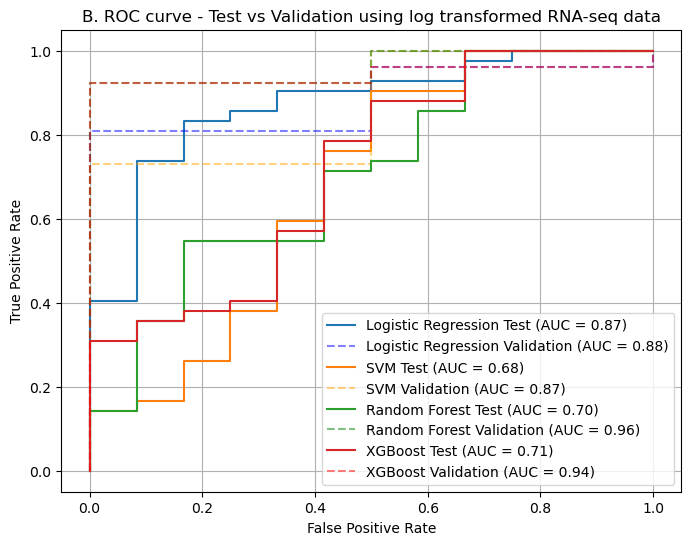

In [123]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('B. ROC curve - Test vs Validation using log transformed RNA-seq data')
plt.legend()
plt.grid(True)
plt.show()


## Scaled

In [124]:
# Get predicted probabilities or decision values for each model
lr_probs = lrmodels.predict_proba(X_tests)[:, 1]  # Logistic Regression
svm_probs = svmodels.decision_function(X_tests)   # SVM
rfc_probs = rfcmodels.predict_proba(X_tests)[:, 1]  # Random Forest
xgb_probs = xgbcmodels.predict_proba(X_tests)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(y_tests, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(y_tests, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(y_tests, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_tests, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [125]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = lrmodels.predict_proba(asca)[:, 1]  # Logistic Regression
svm_probs_val = svmodels.decision_function(asca)    # SVM
rfc_probs_val = rfcmodels.predict_proba(asca)[:, 1]  # Random Forest
xgb_probs_val = xgbcmodels.predict_proba(asca)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(b, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(b, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(b, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(b, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


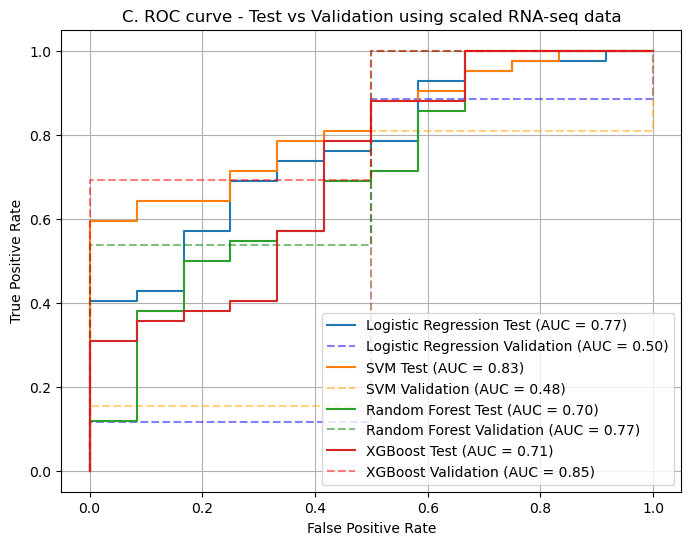

In [126]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('C. ROC curve - Test vs Validation using scaled RNA-seq data')
plt.legend()
plt.grid(True)
plt.show()


## Scaled logged

In [127]:
# Get predicted probabilities or decision values for each model
lr_probs = lrmo.predict_proba(Xtest)[:, 1]  # Logistic Regression
svm_probs = svmo.decision_function(Xtest)   # SVM
rfc_probs = rfcmo.predict_proba(Xtest)[:, 1]  # Random Forest
xgb_probs = xgbcmo.predict_proba(Xtest)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(ytest, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(ytest, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(ytest, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [128]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = lrmo.predict_proba(acorr)[:, 1]  # Logistic Regression
svm_probs_val = svmo.decision_function(acorr)    # SVM
rfc_probs_val = rfcmo.predict_proba(acorr)[:, 1]  # Random Forest
xgb_probs_val = xgbcmo.predict_proba(acorr)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(b, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(b, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(b, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(b, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

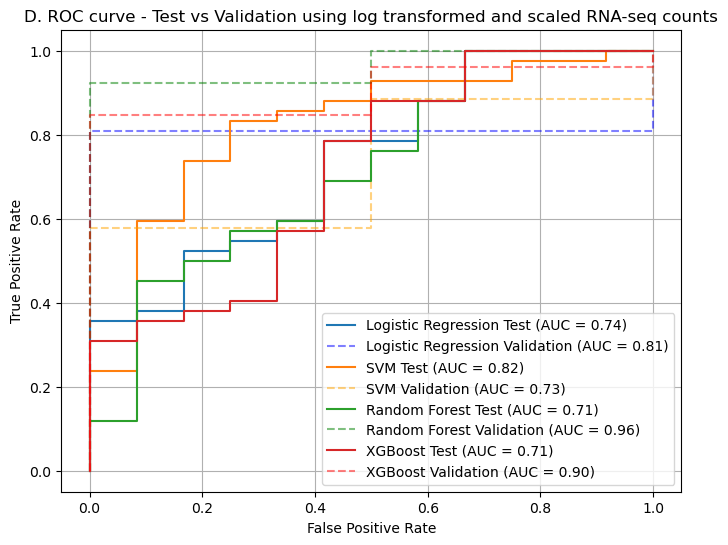

In [129]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('D. ROC curve - Test vs Validation using log transformed and scaled RNA-seq counts')
plt.legend()
plt.grid(True)
plt.show()


# TPM

# ALL TPM XGBC

In [370]:
txgbc1= xgbc
txgbc2= xgbc
txgbc3= xgbc
txgbc4= xgbc

In [375]:
txgbc1.fit(tX_train,ty_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [376]:
txgbc2.fit(tlogX_train, tlogy_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [377]:
txgbc3.fit(tX_trains, ty_trains)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [378]:
txgbc4.fit(tXtrain, tytrain)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'colsample_bytree': [0.01, 0.4],
                             'gamma': [0.01, 0.5], 'grow_policy': ['lossguide'],
                             'importance_type': ['cover'],
                             'learning_rate': [0.01, 0.1], 'max_bin': [30, 45],
                             'max_delta_step': [10, 15], 'max_depth': [5, 15],
                             'max_leaves': [15, 25],
                             'min_child_weight': [0.1, 0.5],
                             'n_estimators': [300, 500],
                             'num_parallel_tree': [3, 10],
                             'objective': ['binary:logistic'],
                             'reg_lambda': [None], 'subsample': [0.6, 0.99]})

In [596]:
txgbc1m = xgb.XGBClassifier(**txgbc1.best_params_)
txgbc2m= xgb.XGBClassifier(**txgbc2.best_params_)
txgbc3m= xgb.XGBClassifier(**txgbc3.best_params_)


In [597]:
trxgbcm= xgb.XGBClassifier(**trxgbc.best_params_)

In [600]:
txgbc1m.fit(tX_train,ty_train)

XGBClassifier(base_score=0.2625121222619956, booster='dart', callbacks=None,
              colsample_bylevel=0.02073495838690962,
              colsample_bynode=0.22088362306356027,
              colsample_bytree=0.04341908799791656, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.42755316904662505,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.03128322197728051,
              max_bin=31, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=5, max_leaves=16,
              min_child_weight=0.4143353488048146, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=388,
              n_jobs=None, num_parallel_tree=3, random_state=None, ...)

In [601]:
txgbc2m.fit(tlogX_train,tlogy_train)

XGBClassifier(base_score=0.2625121222619956, booster='dart', callbacks=None,
              colsample_bylevel=0.02073495838690962,
              colsample_bynode=0.22088362306356027,
              colsample_bytree=0.04341908799791656, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.42755316904662505,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.03128322197728051,
              max_bin=31, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=5, max_leaves=16,
              min_child_weight=0.4143353488048146, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=388,
              n_jobs=None, num_parallel_tree=3, random_state=None, ...)

In [602]:
txgbc3m.fit(tX_trains,ty_trains)

XGBClassifier(base_score=0.2625121222619956, booster='dart', callbacks=None,
              colsample_bylevel=0.02073495838690962,
              colsample_bynode=0.22088362306356027,
              colsample_bytree=0.04341908799791656, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.42755316904662505,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.03128322197728051,
              max_bin=31, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=5, max_leaves=16,
              min_child_weight=0.4143353488048146, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=388,
              n_jobs=None, num_parallel_tree=3, random_state=None, ...)

In [618]:
trxgbcm.fit(trXtrain,trytrain)

XGBClassifier(base_score=0.2625121222619956, booster='dart', callbacks=None,
              colsample_bylevel=0.02073495838690962,
              colsample_bynode=0.22088362306356027,
              colsample_bytree=0.04341908799791656, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.42755316904662505,
              grow_policy='lossguide', importance_type='cover',
              interaction_constraints=None, learning_rate=0.03128322197728051,
              max_bin=31, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=14, max_depth=5, max_leaves=16,
              min_child_weight=0.4143353488048146, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=388,
              n_jobs=None, num_parallel_tree=3, random_state=None, ...)

# No scaling or normalization

## LR TPM

In [323]:
lr.fit(tX_train, ty_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

### Retraining

In [324]:
tlr = LogisticRegression(**lr.best_params_)

In [325]:
tlr.fit(tX_train,ty_train)

LogisticRegression(class_weight='balanced', max_iter=1898, solver='liblinear')

## SVM TPM

In [327]:
svm.fit(tX_train, ty_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

In [333]:
tsvm = SVC(**svm.best_params_)

In [359]:
tsvm.fit(tX_train,ty_train)

SVC(C=100.0, kernel='poly')

## RFC TPM

In [329]:
rfc.fit(tX_train,ty_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

In [362]:
trfc = RandomForestClassifier(**rfc.best_params_)

In [363]:
trfc.fit(tX_train, ty_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18,
                       min_impurity_decrease=0.012098169376474623,
                       min_weight_fraction_leaf=0.07, n_estimators=300)

# model eval

### LR

In [518]:
allscore(tlr,tX_test,ty_test)

Accuracy: 0.7962962962962963
Precision: 0.918918918918919
Recall: 0.8095238095238095
F1 Score: 0.860759493670886
Confusion Matrix:
 [[ 9  3]
 [ 8 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.75      0.62        12
           1       0.92      0.81      0.86        42

    accuracy                           0.80        54
   macro avg       0.72      0.78      0.74        54
weighted avg       0.83      0.80      0.81        54



In [527]:
allscore(tlr,ta,tb)

Accuracy: 0.6785714285714286
Precision: 0.9473684210526315
Recall: 0.6923076923076923
F1 Score: 0.7999999999999999
Confusion Matrix:
 [[ 1  1]
 [ 8 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.50      0.18         2
           1       0.95      0.69      0.80        26

    accuracy                           0.68        28
   macro avg       0.53      0.60      0.49        28
weighted avg       0.89      0.68      0.76        28



### SVM

In [530]:
allscore(tsvm, tX_test,ty_test)

Accuracy: 0.7592592592592593
Precision: 0.8085106382978723
Recall: 0.9047619047619048
F1 Score: 0.853932584269663
Confusion Matrix:
 [[ 3  9]
 [ 4 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.25      0.32        12
           1       0.81      0.90      0.85        42

    accuracy                           0.76        54
   macro avg       0.62      0.58      0.58        54
weighted avg       0.72      0.76      0.73        54



In [531]:
allscore(tsvm, ta,tb)

Accuracy: 0.8928571428571429
Precision: 0.9259259259259259
Recall: 0.9615384615384616
F1 Score: 0.9433962264150944
Confusion Matrix:
 [[ 0  2]
 [ 1 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      0.96      0.94        26

    accuracy                           0.89        28
   macro avg       0.46      0.48      0.47        28
weighted avg       0.86      0.89      0.88        28



### RFC

In [528]:
allscore(trfc, tX_test, ty_test)

Accuracy: 0.7592592592592593
Precision: 0.8372093023255814
Recall: 0.8571428571428571
F1 Score: 0.8470588235294119
Confusion Matrix:
 [[ 5  7]
 [ 6 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.84      0.86      0.85        42

    accuracy                           0.76        54
   macro avg       0.65      0.64      0.64        54
weighted avg       0.75      0.76      0.76        54



In [529]:
allscore(trfc,ta,tb)

Accuracy: 0.9285714285714286
Precision: 0.9615384615384616
Recall: 0.9615384615384616
F1 Score: 0.9615384615384616
Confusion Matrix:
 [[ 1  1]
 [ 1 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.96      0.96      0.96        26

    accuracy                           0.93        28
   macro avg       0.73      0.73      0.73        28
weighted avg       0.93      0.93      0.93        28



### XGBC

In [604]:
allscore(txgbc1m,tX_test,ty_test)

Accuracy: 0.7407407407407407
Precision: 0.8043478260869565
Recall: 0.8809523809523809
F1 Score: 0.8409090909090908
Confusion Matrix:
 [[ 3  9]
 [ 5 37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.25      0.30        12
           1       0.80      0.88      0.84        42

    accuracy                           0.74        54
   macro avg       0.59      0.57      0.57        54
weighted avg       0.71      0.74      0.72        54



In [605]:
allscore(txgbc1m,ta,tb)

Accuracy: 0.9285714285714286
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963
Confusion Matrix:
 [[ 0  2]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        26

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logged

## LR

In [532]:
lr.fit(tlogX_train,tlogy_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

In [533]:
tlolr= LogisticRegression(**lr.best_params_)

In [534]:
tlolr.fit(tlogX_train,tlogy_train)

LogisticRegression(C=10.0, class_weight='balanced', max_iter=2712,
                   solver='newton-cholesky')

### SVM

In [536]:
svm.fit(tlogX_train,tlogy_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

In [537]:
tlosvm= SVC(**svm.best_params_)

In [538]:
tlosvm.fit(tlogX_train,tlogy_train)

SVC(kernel='poly')

### RFC

In [539]:
rfc.fit(tlogX_train,tlogy_train)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

In [540]:
tlorfc= RandomForestClassifier(**rfc.best_params_)

In [541]:
tlorfc.fit(tlogX_train,tlogy_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18, min_impurity_decrease=0.01,
                       min_samples_leaf=3, min_weight_fraction_leaf=0.07,
                       n_estimators=500)

# model eval

### LR

In [557]:
allscore(tlolr,tlogX_test,tlogy_test)

Accuracy: 0.7407407407407407
Precision: 0.8888888888888888
Recall: 0.7619047619047619
F1 Score: 0.8205128205128205
Confusion Matrix:
 [[ 8  4]
 [10 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.67      0.53        12
           1       0.89      0.76      0.82        42

    accuracy                           0.74        54
   macro avg       0.67      0.71      0.68        54
weighted avg       0.79      0.74      0.76        54



In [562]:
allscore(tlolr,tlogvala,tb)

Accuracy: 0.7142857142857143
Precision: 0.95
Recall: 0.7307692307692307
F1 Score: 0.8260869565217392
Confusion Matrix:
 [[ 1  1]
 [ 7 19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.50      0.20         2
           1       0.95      0.73      0.83        26

    accuracy                           0.71        28
   macro avg       0.54      0.62      0.51        28
weighted avg       0.89      0.71      0.78        28



### svm

In [563]:
allscore(tsvm,tlogX_test,tlogy_test)

Accuracy: 0.7777777777777778
Precision: 0.7777777777777778
Recall: 1.0
F1 Score: 0.8750000000000001
Confusion Matrix:
 [[ 0 12]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.78      1.00      0.88        42

    accuracy                           0.78        54
   macro avg       0.39      0.50      0.44        54
weighted avg       0.60      0.78      0.68        54



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [564]:
allscore(tsvm,tlogvala,tb)

Accuracy: 0.9285714285714286
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963
Confusion Matrix:
 [[ 0  2]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        26

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RFC

In [565]:
allscore(trfc,tlogX_test,tlogy_test)

Accuracy: 0.7777777777777778
Precision: 0.8409090909090909
Recall: 0.8809523809523809
F1 Score: 0.8604651162790699
Confusion Matrix:
 [[ 5  7]
 [ 5 37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.42      0.45        12
           1       0.84      0.88      0.86        42

    accuracy                           0.78        54
   macro avg       0.67      0.65      0.66        54
weighted avg       0.77      0.78      0.77        54



In [566]:
allscore(trfc, tlogvala,tb)

Accuracy: 0.9642857142857143
Precision: 0.9629629629629629
Recall: 1.0
F1 Score: 0.9811320754716981
Confusion Matrix:
 [[ 1  1]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.96      1.00      0.98        26

    accuracy                           0.96        28
   macro avg       0.98      0.75      0.82        28
weighted avg       0.97      0.96      0.96        28



### XGBC

In [47]:
allscore(txgbc2m,tlogX_test,tlogy_test)

NameError: name 'txgbc2m' is not defined

In [607]:
allscore(txgbc2m,tlogvala,tb)

Accuracy: 0.9285714285714286
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963
Confusion Matrix:
 [[ 0  2]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        26

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Scaled

### LR

In [542]:
lr.fit(tX_trains, ty_trains)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

In [543]:
tlrmodels= LogisticRegression(**lr.best_params_)

In [544]:
tlrmodels.fit(tX_trains,ty_trains)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=2243,
                   solver='newton-cholesky')

### SVM

In [545]:
svm.fit(tX_trains,ty_trains)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

In [546]:
tsvmodels= SVC(**svm.best_params_)

In [547]:
tsvmodels.fit(tX_trains,ty_trains)

SVC(C=100.0, gamma='auto')

### RFC

In [548]:
rfc.fit(tX_trains,ty_trains)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

In [549]:
trfcmodels= RandomForestClassifier(**rfc.best_params_)

In [550]:
trfcmodels.fit(tX_trains, ty_trains)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18,
                       min_impurity_decrease=0.020850578565347982,
                       min_weight_fraction_leaf=0.07, n_estimators=300)

# Model eval

### LR

In [551]:
allscore(tlrmodels, tX_tests,ty_tests)

Accuracy: 0.7962962962962963
Precision: 0.8444444444444444
Recall: 0.9047619047619048
F1 Score: 0.8735632183908046
Confusion Matrix:
 [[ 5  7]
 [ 4 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.84      0.90      0.87        42

    accuracy                           0.80        54
   macro avg       0.70      0.66      0.67        54
weighted avg       0.78      0.80      0.79        54



In [567]:
allscore(tlrmodels,tasca,tb)

Accuracy: 0.35714285714285715
Precision: 0.9
Recall: 0.34615384615384615
F1 Score: 0.5
Confusion Matrix:
 [[ 1  1]
 [17  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.50      0.10         2
           1       0.90      0.35      0.50        26

    accuracy                           0.36        28
   macro avg       0.48      0.42      0.30        28
weighted avg       0.84      0.36      0.47        28



### svm

In [553]:
allscore(tsvmodels,tX_tests,ty_tests)

Accuracy: 0.7962962962962963
Precision: 0.8163265306122449
Recall: 0.9523809523809523
F1 Score: 0.8791208791208791
Confusion Matrix:
 [[ 3  9]
 [ 2 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.25      0.35        12
           1       0.82      0.95      0.88        42

    accuracy                           0.80        54
   macro avg       0.71      0.60      0.62        54
weighted avg       0.77      0.80      0.76        54



In [568]:
allscore(tsvmodels,tasca,tb)

Accuracy: 0.6071428571428571
Precision: 0.9411764705882353
Recall: 0.6153846153846154
F1 Score: 0.744186046511628
Confusion Matrix:
 [[ 1  1]
 [10 16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.50      0.15         2
           1       0.94      0.62      0.74        26

    accuracy                           0.61        28
   macro avg       0.52      0.56      0.45        28
weighted avg       0.88      0.61      0.70        28



### RFC

In [555]:
allscore(trfcmodels,tX_tests,ty_tests)

Accuracy: 0.7592592592592593
Precision: 0.8372093023255814
Recall: 0.8571428571428571
F1 Score: 0.8470588235294119
Confusion Matrix:
 [[ 5  7]
 [ 6 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.84      0.86      0.85        42

    accuracy                           0.76        54
   macro avg       0.65      0.64      0.64        54
weighted avg       0.75      0.76      0.76        54



In [569]:
allscore(trfcmodels,tasca,tb)

Accuracy: 0.9285714285714286
Precision: 0.9615384615384616
Recall: 0.9615384615384616
F1 Score: 0.9615384615384616
Confusion Matrix:
 [[ 1  1]
 [ 1 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.96      0.96      0.96        26

    accuracy                           0.93        28
   macro avg       0.73      0.73      0.73        28
weighted avg       0.93      0.93      0.93        28



### XGBC

In [610]:
allscore(txgbc3m,tX_tests,ty_tests)

Accuracy: 0.8148148148148148
Precision: 0.8076923076923077
Recall: 1.0
F1 Score: 0.8936170212765957
Confusion Matrix:
 [[ 2 10]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.81      1.00      0.89        42

    accuracy                           0.81        54
   macro avg       0.90      0.58      0.59        54
weighted avg       0.85      0.81      0.76        54



In [613]:
allscore(txgbc3m,tasca,tb)

Accuracy: 0.9285714285714286
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963
Confusion Matrix:
 [[ 0  2]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      1.00      0.96        26

    accuracy                           0.93        28
   macro avg       0.46      0.50      0.48        28
weighted avg       0.86      0.93      0.89        28



C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hasan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logged and scaled

## LR

In [623]:
lr.fit(trXtrain,trytrain)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=LogisticRegression(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'class_weight': ['balanced'],
                             'max_iter': [100, 10000],
                             'solver': ['liblinear', 'newton-cholesky']})

In [571]:
tlrmo= LogisticRegression(**lr.best_params_)

In [624]:
tlrmo.fit(trXtrain,trytrain)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=2136,
                   solver='newton-cholesky')

## SVM

In [625]:
svm.fit(trXtrain, trytrain)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\

BayesSearchCV(cv=5, estimator=SVC(), random_state=69,
              search_spaces={'C': [0.01, 0.1, 1.0, 10.0, 100],
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'poly', 'rbf']})

In [574]:
tsvmo=SVC(**svm.best_params_)

In [626]:
tsvmo.fit(trXtrain,trytrain)

SVC(C=10.0, kernel='linear')

## RFC

In [627]:
rfc.fit(trXtrain, trytrain)

C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Hasan\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), random_state=69,
              search_spaces={'bootstrap': [False],
                             'ccp_alpha': [0.01, 0.1, 0.0, 1.0, 10],
                             'class_weight': ['balanced'],
                             'criterion': ['entropy'], 'max_depth': [5, 15],
                             'max_features': ['log2'], 'max_leaf_nodes': [18],
                             'max_samples': [None],
                             'min_impurity_decrease': [0.01, 0.1],
                             'min_samples_leaf': [1, 2, 3, 4],
                             'min_samples_split': [2, 6],
                             'min_weight_fraction_leaf': [0.07],
                             'n_estimators': [300, 500]})

In [578]:
trfcmo= RandomForestClassifier(**rfc.best_params_)

In [628]:
trfcmo.fit(trXtrain,trytrain)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='log2',
                       max_leaf_nodes=18, min_impurity_decrease=0.01,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.07, n_estimators=500)

# model eval

### LR

In [629]:
allscore(tlrmo,trXtest,trytest)

Accuracy: 0.7962962962962963
Precision: 0.8780487804878049
Recall: 0.8571428571428571
F1 Score: 0.8674698795180722
Confusion Matrix:
 [[ 7  5]
 [ 6 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.58      0.56        12
           1       0.88      0.86      0.87        42

    accuracy                           0.80        54
   macro avg       0.71      0.72      0.71        54
weighted avg       0.80      0.80      0.80        54



In [582]:
allscore(tlrmo,tracorr,tb)

Accuracy: 0.25
Precision: 0.8571428571428571
Recall: 0.23076923076923078
F1 Score: 0.36363636363636365
Confusion Matrix:
 [[ 1  1]
 [20  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.50      0.09         2
           1       0.86      0.23      0.36        26

    accuracy                           0.25        28
   macro avg       0.45      0.37      0.23        28
weighted avg       0.80      0.25      0.34        28



### svm

In [630]:
allscore(tsvmo,trXtest,trytest)

Accuracy: 0.7962962962962963
Precision: 0.8163265306122449
Recall: 0.9523809523809523
F1 Score: 0.8791208791208791
Confusion Matrix:
 [[ 3  9]
 [ 2 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.25      0.35        12
           1       0.82      0.95      0.88        42

    accuracy                           0.80        54
   macro avg       0.71      0.60      0.62        54
weighted avg       0.77      0.80      0.76        54



In [583]:
allscore(tsvmo,tracorr,tb)

Accuracy: 0.5357142857142857
Precision: 0.9333333333333333
Recall: 0.5384615384615384
F1 Score: 0.6829268292682926
Confusion Matrix:
 [[ 1  1]
 [12 14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.50      0.13         2
           1       0.93      0.54      0.68        26

    accuracy                           0.54        28
   macro avg       0.51      0.52      0.41        28
weighted avg       0.87      0.54      0.64        28



### rfc

In [631]:
allscore(trfcmo,trXtest,trytest)

Accuracy: 0.7592592592592593
Precision: 0.8372093023255814
Recall: 0.8571428571428571
F1 Score: 0.8470588235294119
Confusion Matrix:
 [[ 5  7]
 [ 6 36]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.84      0.86      0.85        42

    accuracy                           0.76        54
   macro avg       0.65      0.64      0.64        54
weighted avg       0.75      0.76      0.76        54



In [593]:
allscore(trfcmo,tracorr,tb)

Accuracy: 0.9642857142857143
Precision: 0.9629629629629629
Recall: 1.0
F1 Score: 0.9811320754716981
Confusion Matrix:
 [[ 1  1]
 [ 0 26]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.96      1.00      0.98        26

    accuracy                           0.96        28
   macro avg       0.98      0.75      0.82        28
weighted avg       0.97      0.96      0.96        28



### xgbc

In [619]:
allscore(trxgbc,trXtest,trytest)

Accuracy: 0.8148148148148148
Precision: 0.8076923076923077
Recall: 1.0
F1 Score: 0.8936170212765957
Confusion Matrix:
 [[ 2 10]
 [ 0 42]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.81      1.00      0.89        42

    accuracy                           0.81        54
   macro avg       0.90      0.58      0.59        54
weighted avg       0.85      0.81      0.76        54



In [620]:
allscore(trxgbc,tracorr,tb)

Accuracy: 0.8928571428571429
Precision: 0.9259259259259259
Recall: 0.9615384615384616
F1 Score: 0.9433962264150944
Confusion Matrix:
 [[ 0  2]
 [ 1 25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      0.96      0.94        26

    accuracy                           0.89        28
   macro avg       0.46      0.48      0.47        28
weighted avg       0.86      0.89      0.88        28



# TPM visualizations

## Nonscaled nonlogged

In [648]:
# Get predicted probabilities or decision values for each model
lr_probs = tlr.predict_proba(tX_test)[:, 1]  # Logistic Regression
svm_probs = tsvm.decision_function(tX_test)   # SVM
rfc_probs = trfc.predict_proba(tX_test)[:, 1]  # Random Forest
xgb_probs = txgbc1m.predict_proba(tX_test)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [649]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = tlr.predict_proba(ta)[:, 1]  # Logistic Regression
svm_probs_val = tsvm.decision_function(ta)    # SVM
rfc_probs_val = trfc.predict_proba(ta)[:, 1]  # Random Forest
xgb_probs_val = txgbc1m.predict_proba(ta)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(tb, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(tb, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(tb, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(tb, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

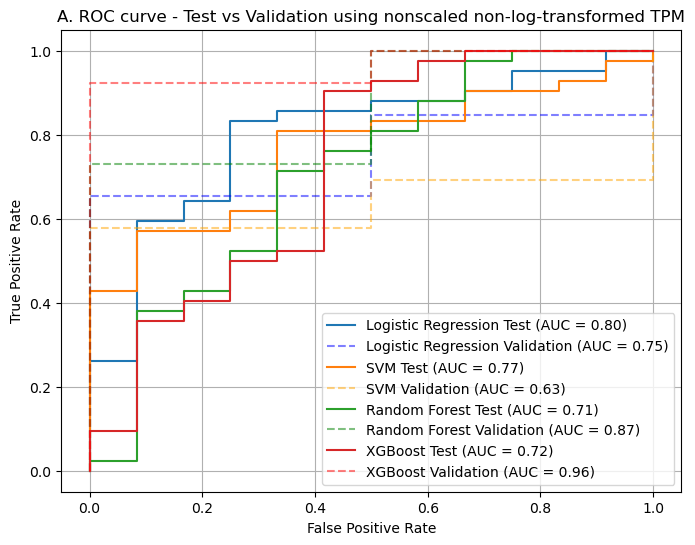

In [650]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('A. ROC curve - Test vs Validation using nonscaled non-log-transformed TPM')
plt.legend()
plt.grid(True)
plt.show()


## logged

In [656]:
# Get predicted probabilities or decision values for each model
lr_probs = tlolr.predict_proba(tlogX_test)[:, 1]  # Logistic Regression
svm_probs = tlosvm.decision_function(tlogX_test)   # SVM
rfc_probs = tlorfc.predict_proba(tlogX_test)[:, 1]  # Random Forest
xgb_probs = txgbc2m.predict_proba(tlogX_test)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(tlogy_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(tlogy_test, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(tlogy_test, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(tlogy_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [657]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = tlolr.predict_proba(tlogvala)[:, 1]  # Logistic Regression
svm_probs_val = tlosvm.decision_function(tlogvala)    # SVM
rfc_probs_val = tlorfc.predict_proba(tlogvala)[:, 1]  # Random Forest
xgb_probs_val = txgbc2m.predict_proba(tlogvala)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(tb, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(tb, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(tb, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(tb, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

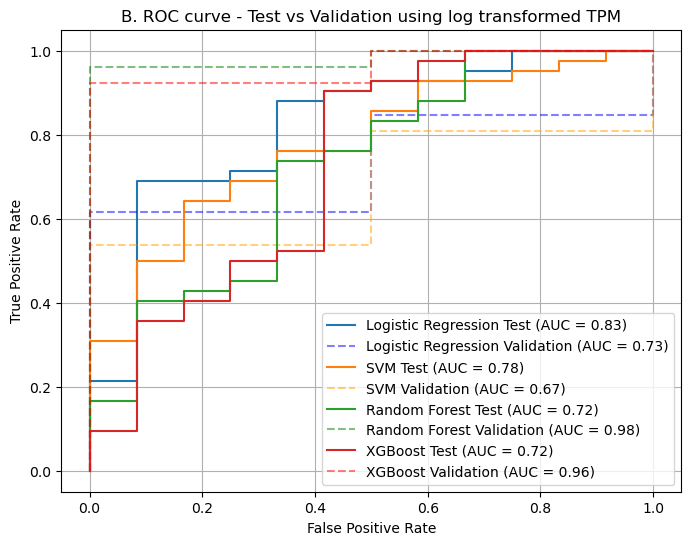

In [658]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('B. ROC curve - Test vs Validation using log transformed TPM')
plt.legend()
plt.grid(True)
plt.show()


## Scaled

In [659]:
# Get predicted probabilities or decision values for each model
lr_probs = tlrmodels.predict_proba(tX_tests)[:, 1]  # Logistic Regression
svm_probs = tsvmodels.decision_function(tX_tests)   # SVM
rfc_probs = trfcmodels.predict_proba(tX_tests)[:, 1]  # Random Forest
xgb_probs = txgbc3m.predict_proba(tX_tests)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(ty_tests, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(ty_tests, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(ty_tests, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(ty_tests, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [660]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = tlrmodels.predict_proba(tasca)[:, 1]  # Logistic Regression
svm_probs_val = tsvmodels.decision_function(tasca)    # SVM
rfc_probs_val = trfcmodels.predict_proba(tasca)[:, 1]  # Random Forest
xgb_probs_val = txgbc3m.predict_proba(tasca)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(tb, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(tb, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(tb, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(tb, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

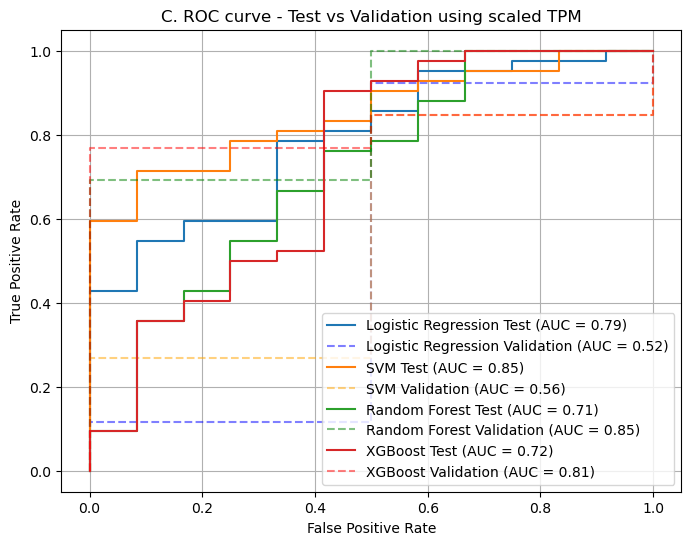

In [661]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('C. ROC curve - Test vs Validation using scaled TPM')
plt.legend()
plt.grid(True)
plt.show()


## Scaled logged

In [662]:
# Get predicted probabilities or decision values for each model
lr_probs = tlrmo.predict_proba(trXtest)[:, 1]  # Logistic Regression
svm_probs = tsvmo.decision_function(trXtest)   # SVM
rfc_probs = trfcmo.predict_proba(trXtest)[:, 1]  # Random Forest
xgb_probs = trxgbcm.predict_proba(trXtest)[:, 1]  # XGBoost


# Calculate ROC and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(trytest, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

svm_fpr, svm_tpr, _ = roc_curve(trytest, svm_probs)
svm_auc = auc(svm_fpr, svm_tpr)

rfc_fpr, rfc_tpr, _ = roc_curve(trytest, rfc_probs)
rfc_auc = auc(rfc_fpr, rfc_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(trytest, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [663]:
# Get predicted probabilities or decision values for each model using validation data
lr_probs_val = tlrmo.predict_proba(tracorr)[:, 1]  # Logistic Regression
svm_probs_val = tsvmo.decision_function(tracorr)    # SVM
rfc_probs_val = trfcmo.predict_proba(tracorr)[:, 1]  # Random Forest
xgb_probs_val = trxgbcm.predict_proba(tracorr)[:, 1]   # XGBoost

# Calculate ROC and AUC for each model using validation data
lr_fpr_val, lr_tpr_val, _ = roc_curve(tb, lr_probs_val)
lr_auc_val = auc(lr_fpr_val, lr_tpr_val)

svm_fpr_val, svm_tpr_val, _ = roc_curve(tb, svm_probs_val)
svm_auc_val = auc(svm_fpr_val, svm_tpr_val)

rfc_fpr_val, rfc_tpr_val, _ = roc_curve(tb, rfc_probs_val)
rfc_auc_val = auc(rfc_fpr_val, rfc_tpr_val)

xgb_fpr_val, xgb_tpr_val, _ = roc_curve(tb, xgb_probs_val)
xgb_auc_val = auc(xgb_fpr_val, xgb_tpr_val)

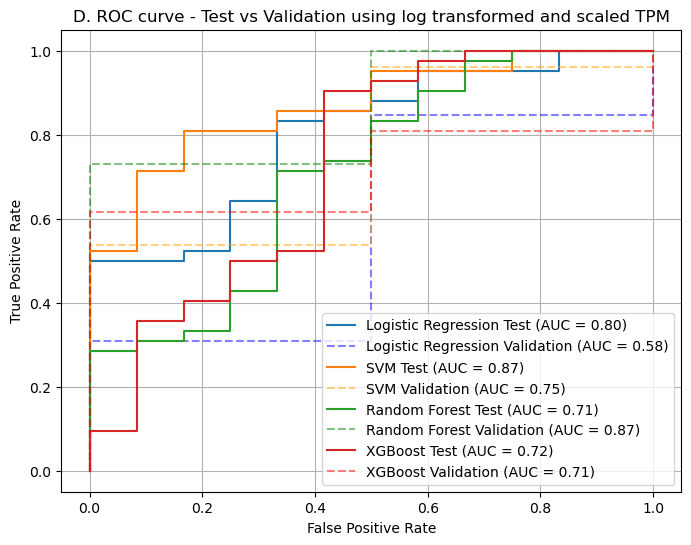

In [664]:
# Plotting ROC curves for test and validation sets together
plt.figure(figsize=(8, 6))

# Plotting test set ROC curves
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression Test (AUC = {lr_auc:.2f})')
plt.plot(lr_fpr_val, lr_tpr_val, linestyle='--', color='blue', alpha=0.5, label=f'Logistic Regression Validation (AUC = {lr_auc_val:.2f})')

plt.plot(svm_fpr, svm_tpr, label=f'SVM Test (AUC = {svm_auc:.2f})')
plt.plot(svm_fpr_val, svm_tpr_val, linestyle='--', color='orange', alpha=0.5, label=f'SVM Validation (AUC = {svm_auc_val:.2f})')


plt.plot(rfc_fpr, rfc_tpr, label=f'Random Forest Test (AUC = {rfc_auc:.2f})')
plt.plot(rfc_fpr_val, rfc_tpr_val, linestyle='--', color='green', alpha=0.5, label=f'Random Forest Validation (AUC = {rfc_auc_val:.2f})')

plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost Test (AUC = {xgb_auc:.2f})')
plt.plot(xgb_fpr_val, xgb_tpr_val, linestyle='--', color='red', alpha=0.5, label=f'XGBoost Validation (AUC = {xgb_auc_val:.2f})')

# Plotting validation set ROC curves with strikethrough lines


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('D. ROC curve - Test vs Validation using log transformed and scaled TPM')
plt.legend()
plt.grid(True)
plt.show()
